# Task 1 - PneumoniaMNIST Classification with a Custom CNN (PyTorch GPU)

### Cell 1 - (Optional) Install missing packages
Use only in fresh environments (e.g., Colab). Installs `medmnist` and `torchvision` if needed.



In [ ]:
# If running in a new environment (e.g., Colab), uncomment:
# !pip -q install medmnist torchvision torch --extra-index-url https://download.pytorch.org/whl/cu118

### Cell 2 - Imports, reproducibility, and GPU setup
Imports all libs, sets seeds, selects GPU if available, and prints device info.



In [ ]:
import os
import json
import random
from pathlib import Path

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)

import medmnist
from medmnist import INFO

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# If using Apple Slicon M1/M2/M --> uncomment the next two lines
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)


# If using Windows OS/Google Colab --> uncomment the lines below
# if torch.cuda.is_available():
#     print(f"GPU is available: {torch.cuda.get_device_name(0)}")
# else:
#     print("GPU not available, training will run on CPU.")


mps


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Classic + paper defaults
sns.set_theme(style="ticks", context="paper", palette="colorblind")

mpl.rcParams.update({
    # figure sizing (single-column friendly)
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,

    # typography (journal classic)
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "STIXGeneral", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,

    # clean axes
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,

    # lines
    "lines.linewidth": 1.6,
    "lines.markersize": 4,
})


### Cell 3 - Load PneumoniaMNIST (train/val/test)
Uses MedMNIST v2 official splits for fair evaluation. Prints shapes and class names.



In [4]:
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_data = DataClass(split='train', download=True)
val_data = DataClass(split='val', download=True)
test_data = DataClass(split='test', download=True)

x_train, y_train = train_data.imgs, train_data.labels
x_val, y_val = val_data.imgs, val_data.labels
x_test, y_test = test_data.imgs, test_data.labels

label_map = info['label']
class_names = [label_map[str(i)] for i in range(len(label_map))]

print('Train:', x_train.shape, y_train.shape)
print('Val:  ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)
print('Classes:', class_names)



Train: (4708, 28, 28) (4708, 1)
Val:   (524, 28, 28) (524, 1)
Test:  (624, 28, 28) (624, 1)
Classes: ['normal', 'pneumonia']


### Cell 4 - Class distribution check
Bar plot to understand imbalance and motivate class weights.



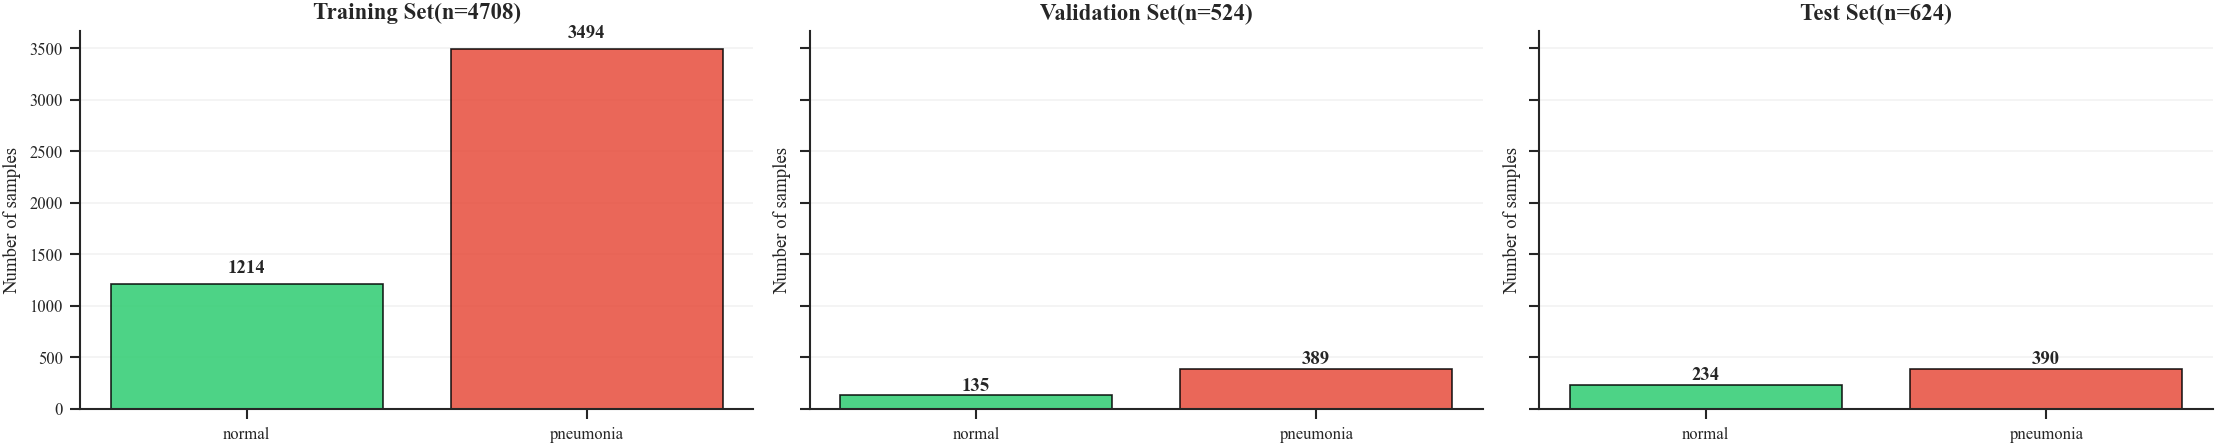

In [5]:
# Class distribution across splits

def count_split(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return {class_names[int(k)]: int(v) for k, v in zip(unique, counts)}

train_counts = count_split(y_train)
val_counts   = count_split(y_val)
test_counts  = count_split(y_test)

splits = [
    ('Training Set', train_counts, len(y_train)),
    ('Validation Set', val_counts, len(y_val)),
    ('Test Set', test_counts, len(y_test)),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 3.2), sharey=True)
colors = ['#2ecc71', '#e74c3c']
for ax, (title, counts, total) in zip(axes, splits):
    labels = list(counts.keys())
    values = [counts[k] for k in labels]
    bars = ax.bar(labels, values, color=colors, alpha=0.85, edgecolor='black')
    ax.set_title(f"{title}(n={total})", fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of samples')
    ax.grid(axis='y', alpha=0.25)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + max(values)*0.02, f"{int(h)}",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Cell 5 - Visual sanity check (sample images)
Quick grid to confirm labels and modality (grayscale chest X-rays).



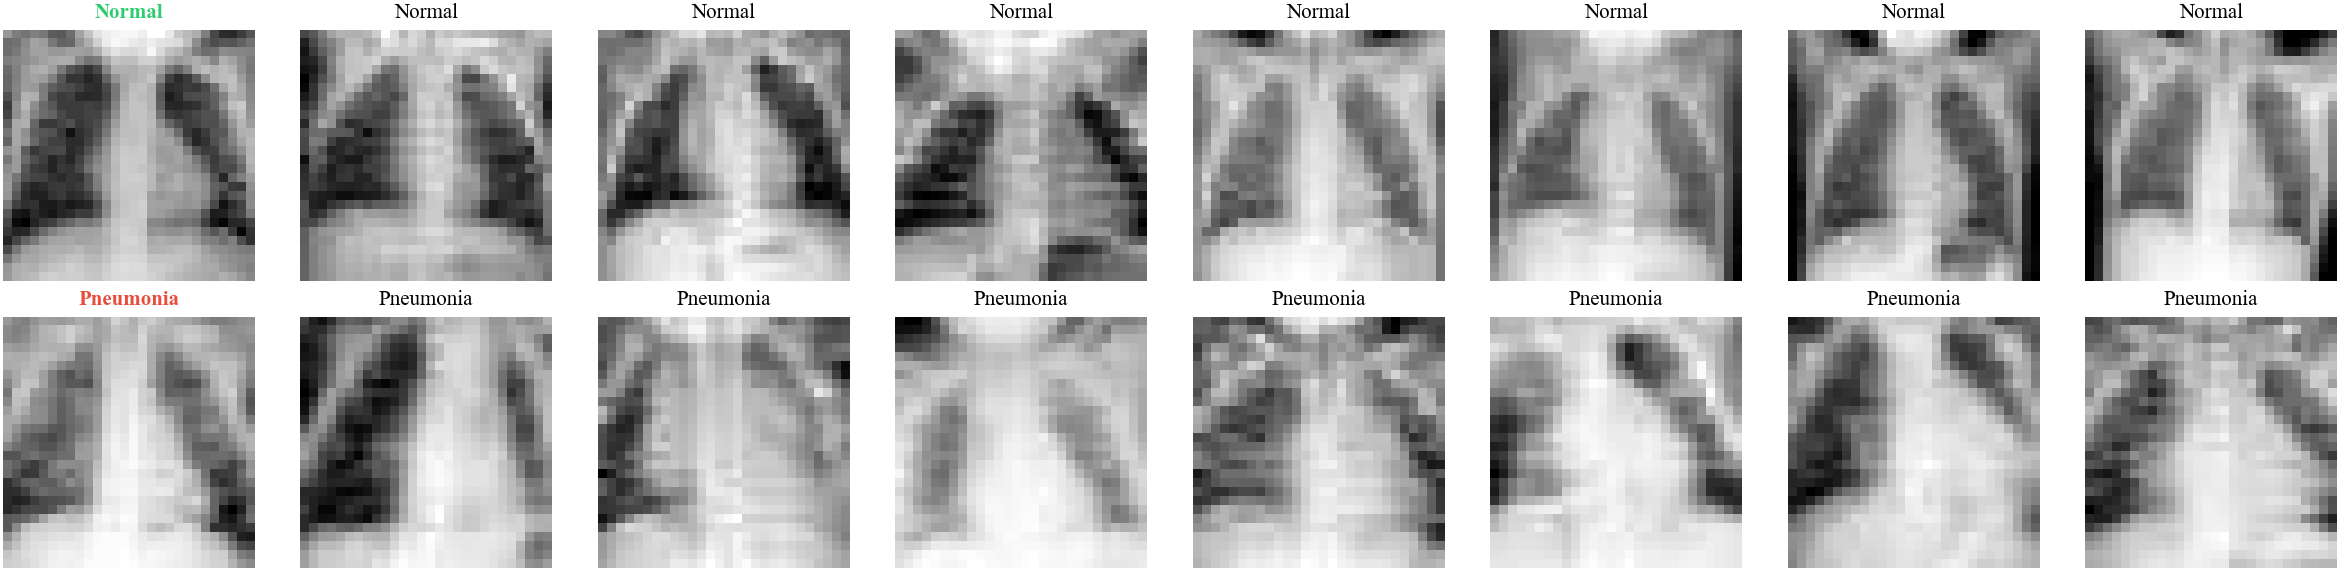

In [6]:
labels = y_train.flatten()
normal_indices = np.where(labels == 0)[0]
pneumonia_indices = np.where(labels == 1)[0]

np.random.seed(42)
normal_samples = np.random.choice(normal_indices, 8, replace=False)
pneumonia_samples = np.random.choice(pneumonia_indices, 8, replace=False)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
# Normal row
for i, idx in enumerate(normal_samples):
    axes[0, i].imshow(x_train[idx], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Normal', fontsize=10,
                      fontweight='bold' if i == 0 else 'normal',
                      color='#2ecc71' if i == 0 else 'black')
# Pneumonia row
for i, idx in enumerate(pneumonia_samples):
    axes[1, i].imshow(x_train[idx], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Pneumonia', fontsize=10,
                      fontweight='bold' if i == 0 else 'normal',
                      color='#e74c3c' if i == 0 else 'black')

plt.tight_layout()
plt.show()


### Cell 6 - Basic pixel statistics
Mean/std after normalizing to [0,1]; supports normalization choices.



Mean pixel intensity: 0.5719
Std  pixel intensity: 0.1684


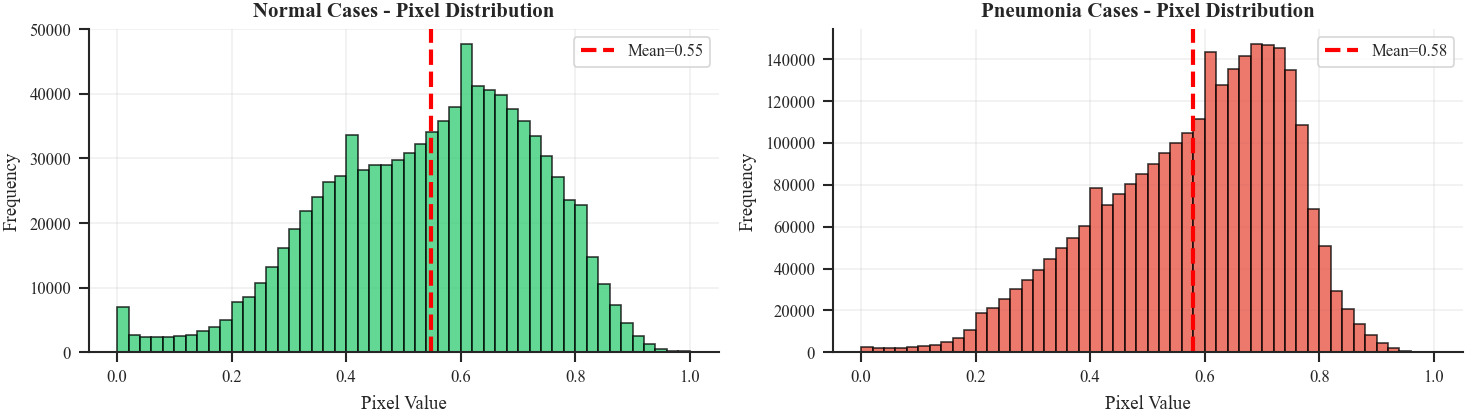

In [7]:
train_pixels = x_train.astype('float32') / 255.0
mean_pixel = float(train_pixels.mean())
std_pixel = float(train_pixels.std())
print(f'Mean pixel intensity: {mean_pixel:.4f}')
print(f'Std  pixel intensity: {std_pixel:.4f}')

labels_px = y_train.flatten()
normal_images = train_pixels[labels_px == 0]
pneumonia_images = train_pixels[labels_px == 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Normal
axes[0].hist(normal_images.flatten(), bins=50, color='#2ecc71', alpha=0.75, edgecolor='black')
axes[0].axvline(np.mean(normal_images), color='red', linestyle='--', linewidth=2,
                label=f'Mean={np.mean(normal_images):.2f}')
axes[0].set_title('Normal Cases - Pixel Distribution', fontweight='bold')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Pneumonia
axes[1].hist(pneumonia_images.flatten(), bins=50, color='#e74c3c', alpha=0.75, edgecolor='black')
axes[1].axvline(np.mean(pneumonia_images), color='red', linestyle='--', linewidth=2,
                label=f'Mean={np.mean(pneumonia_images):.2f}')
axes[1].set_title('Pneumonia Cases - Pixel Distribution', fontweight='bold')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Cell 7 - Configuration, augmentation, and preprocessing helpers
Defines hyperparameters and torchvision-style transforms. Uses native 28x28, light augmentations, and normalizes by dataset mean/std.



In [23]:
config = {
    'image_size': (28, 28),
    'batch_size': 128,
    'epochs': 50,
    'learning_rate': 1e-3,
    'dropout_rate': 0.3,
    'weight_decay': 1e-4,
    'seed': seed,
}

import torchvision.transforms as T

augmentation = T.Compose([
    T.ToTensor(),
    T.RandomRotation(5),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    T.RandomAdjustSharpness(sharpness_factor=1.0, p=0.3),
    T.Normalize(mean=[mean_pixel], std=[std_pixel]),
])

inference_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[mean_pixel], std=[std_pixel]),
])

def make_tensor_dataset(images, labels, transform):
    tensors = []
    for img in images:
        img_t = transform(img)
        tensors.append(img_t)
    x = torch.stack(tensors)
    y = torch.tensor(labels, dtype=torch.long).squeeze()
    return TensorDataset(x, y)



### Cell 8 - Build DataLoaders
Creates train/val/test loaders with augmentation applied only to training data.



In [9]:
train_ds = make_tensor_dataset(x_train, y_train, augmentation)
val_ds = make_tensor_dataset(x_val, y_val, inference_transform)
test_ds = make_tensor_dataset(x_test, y_test, inference_transform)

train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False, drop_last=False)

batch = next(iter(train_loader))
print('Batch images shape:', batch[0].shape)
print('Batch labels shape:', batch[1].shape)



Batch images shape: torch.Size([128, 1, 28, 28])
Batch labels shape: torch.Size([128])


### Cell 9 - Class weights (mitigate imbalance and reduce FP/FN bias)
Inverse-frequency weights for the loss.



In [10]:
unique, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
class_weights = torch.tensor([total / (len(counts) * c) for c in counts], dtype=torch.float32, device=device)
print('Class weights:', class_weights.cpu().numpy())



Class weights: [1.9390445 0.6737264]


### Cell 10 - Architecture inspiration and adaptation
Based on compact pneumonia CNNs (stacked conv blocks + spatial dropout) but downsized for 28x28 to avoid overfitting. Uses 3 blocks (32->64->128), BatchNorm, SpatialDropout, GlobalAvgPool, and a dense head.



### Cell 11 - Build the custom CNN (PyTorch)
Model receives already-augmented tensors from the dataloader (shape: B x 1 x 28 x 28).



In [11]:
class PneumoniaCNN(nn.Module):
    def __init__(self, dropout_rate=0.3, weight_decay=1e-4):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.10),
            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.15),
            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.20),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x.squeeze(1)  # logits

model = PneumoniaCNN(dropout_rate=config['dropout_rate'], weight_decay=config['weight_decay']).to(device)
model = model.to(device)
print(model)

PneumoniaCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### Cell 12 - Optimizer, loss, and callbacks setup
Uses Adam with weight decay; BCEWithLogitsLoss with class weights; implements simple early stopping on val AUC.



In [12]:
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

best_val_auc = 0.0
patience = 8
wait = 0
best_state = None



### Cell 13 - Training loop (with val metrics)
Logs loss, accuracy, AUC each epoch; keeps best model by val AUC; applies early stopping.



In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def evaluate(loader, threshold=0.5):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    probs = sigmoid(logits)
    preds = (probs >= threshold).astype(int)
    auc = roc_auc_score(labels, probs)
    acc = (preds == labels).mean()
    return {'logits': logits, 'labels': labels, 'probs': probs, 'preds': preds, 'auc': auc, 'acc': acc}

train_history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': [], 'auc': [], 'val_auc': []}

for epoch in range(config['epochs']):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        # imgs = imgs.to(device, non_blocking=True)
        labels = labels.float().to(device)
        # labels = labels.to(device, non_blocking=True).float()
        logits = model(imgs)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    # Train metrics
    train_eval = evaluate(train_loader, threshold=0.5)
    val_eval = evaluate(val_loader, threshold=0.5)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_history['loss'].append(epoch_loss)
    train_history['val_loss'].append(0.0)  # placeholder (can compute separately if needed)
    train_history['acc'].append(train_eval['acc'])
    train_history['val_acc'].append(val_eval['acc'])
    train_history['auc'].append(train_eval['auc'])
    train_history['val_auc'].append(val_eval['auc'])

    if val_eval['auc'] > best_val_auc:
        best_val_auc = val_eval['auc']
        best_state = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }
        wait = 0
    else:
        wait += 1

    print(f"Epoch {epoch+1}/{config['epochs']} - loss {epoch_loss:.4f} - val_auc {val_eval['auc']:.4f}")

    if wait >= patience:
        print('Early stopping triggered.')
        break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state['model'])



Epoch 1/100 - loss 0.2707 - val_auc 0.9764
Epoch 2/100 - loss 0.1462 - val_auc 0.9883
Epoch 3/100 - loss 0.1296 - val_auc 0.9877
Epoch 4/100 - loss 0.1039 - val_auc 0.9950
Epoch 5/100 - loss 0.0866 - val_auc 0.9926
Epoch 6/100 - loss 0.0889 - val_auc 0.9954
Epoch 7/100 - loss 0.0755 - val_auc 0.9961
Epoch 8/100 - loss 0.0686 - val_auc 0.9958
Epoch 9/100 - loss 0.0665 - val_auc 0.9961
Epoch 10/100 - loss 0.0527 - val_auc 0.9975
Epoch 11/100 - loss 0.0530 - val_auc 0.9974
Epoch 12/100 - loss 0.0455 - val_auc 0.9973
Epoch 13/100 - loss 0.0344 - val_auc 0.9974
Epoch 14/100 - loss 0.0411 - val_auc 0.9969
Epoch 15/100 - loss 0.0369 - val_auc 0.9973
Epoch 16/100 - loss 0.0351 - val_auc 0.9977
Epoch 17/100 - loss 0.0308 - val_auc 0.9970
Epoch 18/100 - loss 0.0296 - val_auc 0.9977
Epoch 19/100 - loss 0.0252 - val_auc 0.9971
Epoch 20/100 - loss 0.0192 - val_auc 0.9950
Epoch 21/100 - loss 0.0212 - val_auc 0.9977
Epoch 22/100 - loss 0.0169 - val_auc 0.9971
Epoch 23/100 - loss 0.0147 - val_auc 0.99

### Cell 14 - Threshold tuning on the validation set
Sweeps thresholds to maximize F1; returns best threshold.



In [14]:
val_eval = evaluate(val_loader, threshold=0.5)
labels = val_eval['labels']
probs = val_eval['probs']

thresholds = np.linspace(0.05, 0.95, 19)
f1_scores = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(labels, preds))

best_idx = int(np.argmax(f1_scores))
best_threshold = float(thresholds[best_idx])
print('Best threshold:', best_threshold)
print('Best val F1:', f1_scores[best_idx])



Best threshold: 0.05
Best val F1: 0.9844559585492227


### Cell 15 - Evaluate on the test set (metrics)
Computes accuracy, precision, recall, F1, ROC-AUC using the tuned threshold; shows classification report and summary.



In [15]:
test_eval = evaluate(test_loader, threshold=best_threshold)

y_true = test_eval['labels']
y_pred = test_eval['preds']
probs = test_eval['probs']

print(classification_report(y_true, y_pred, target_names=class_names))

roc_auc = roc_auc_score(y_true, probs)
summary_metrics = {
    'accuracy': float((y_pred == y_true).mean()),
    'precision': float(precision_score(y_true, y_pred)),
    'recall': float(recall_score(y_true, y_pred)),
    'f1': float(f1_score(y_true, y_pred)),
    'roc_auc': float(roc_auc),
    'threshold': best_threshold,
}
print('Summary metrics:', summary_metrics)



              precision    recall  f1-score   support

      normal       0.97      0.79      0.87       234
   pneumonia       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624

Summary metrics: {'accuracy': 0.9102564102564102, 'precision': 0.8847926267281107, 'recall': 0.9846153846153847, 'f1': 0.9320388349514563, 'roc_auc': 0.980002191540653, 'threshold': 0.05}


### Cell 16 - Confusion matrix
Visualizes error types.



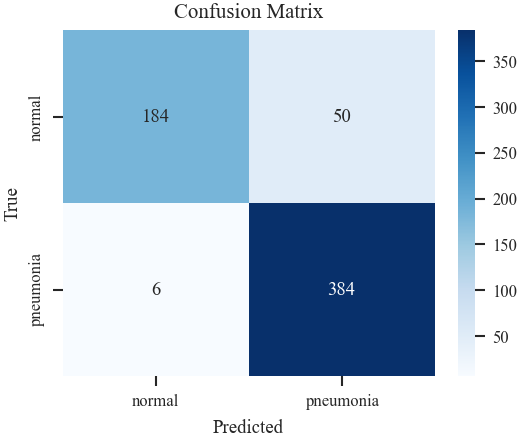

In [16]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



### Cell 17 - ROC curve
Plots ROC and AUC.



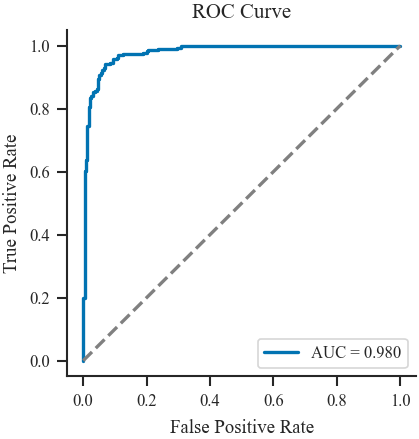

In [17]:
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc_curve = roc_auc_score(y_true, probs)
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_curve:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



### Cell 18 - Training curves (loss, accuracy, AUC)
Shows merged curves for quick overfit/underfit checks.



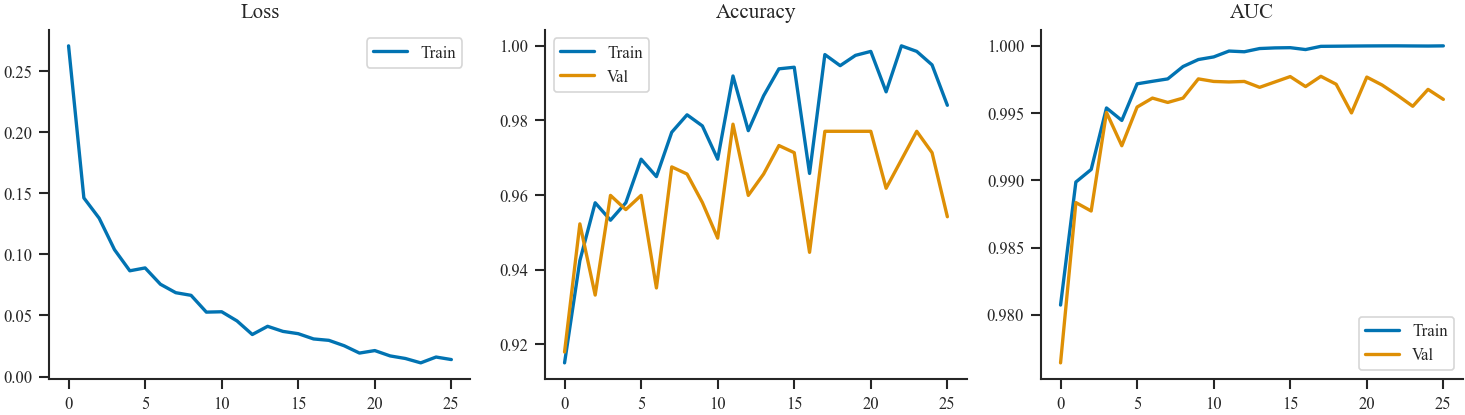

In [18]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(train_history['loss'], label='Train')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_history['acc'], label='Train')
plt.plot(train_history['val_acc'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_history['auc'], label='Train')
plt.plot(train_history['val_auc'], label='Val')
plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()



### Cell 19 - Failure case analysis (FP and FN examples)
Displays a few false positives and false negatives with predicted probabilities.



Error analysis (test set)
Total: 624 | Correct: 568 (91.03%) | Wrong: 56 (8.97%)
TP: 384 | TN: 184 | FP: 50 | FN: 6
Sensitivity/Recall (TP / (TP+FN)): 98.46%
Specificity (TN / (TN+FP)): 78.63%


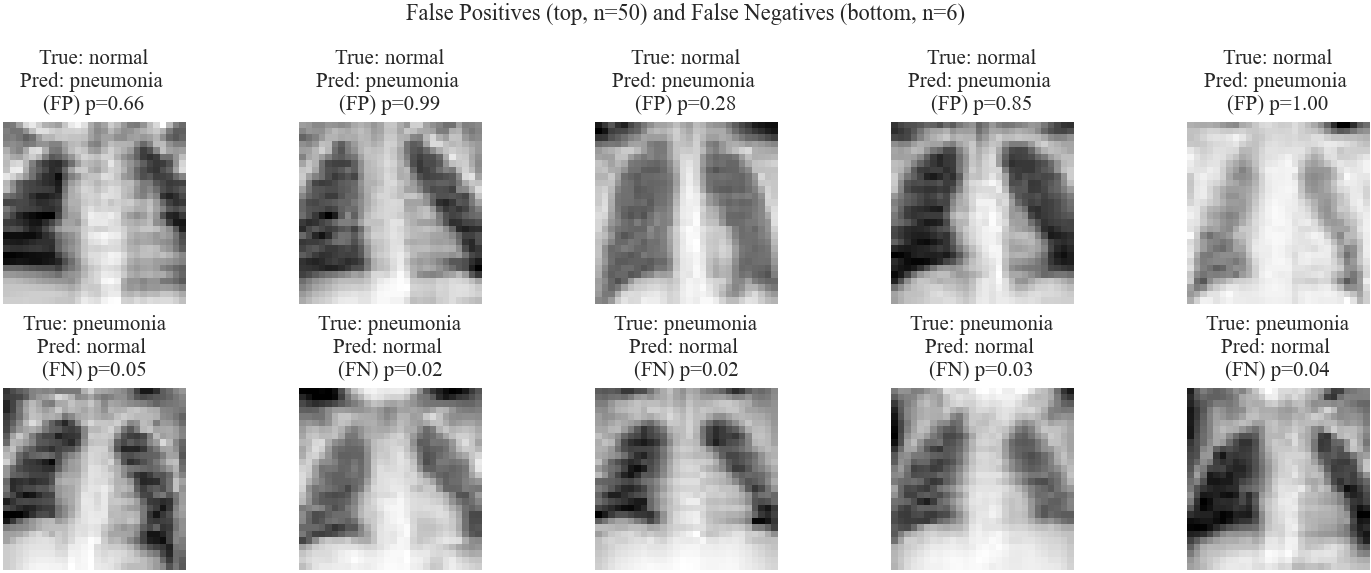

In [20]:
false_positive_indices = np.where((y_pred == 1) & (y_true == 0))[0]
false_negative_indices = np.where((y_pred == 0) & (y_true == 1))[0]

fp_count = len(false_positive_indices)
fn_count = len(false_negative_indices)
tp_count = int(((y_pred == 1) & (y_true == 1)).sum())
tn_count = int(((y_pred == 0) & (y_true == 0)).sum())
total_count = len(y_true)
correct_count = total_count - fp_count - fn_count
wrong_count = fp_count + fn_count

def safe_div(num, den):
    return num / den if den else 0.0

print("Error analysis (test set)")
print(
    f"Total: {total_count} | "
    f"Correct: {correct_count} ({safe_div(correct_count, total_count):.2%}) | "
    f"Wrong: {wrong_count} ({safe_div(wrong_count, total_count):.2%})"
)
print(f"TP: {tp_count} | TN: {tn_count} | FP: {fp_count} | FN: {fn_count}")
print(f"Sensitivity/Recall (TP / (TP+FN)): {safe_div(tp_count, tp_count + fn_count):.2%}")
print(f"Specificity (TN / (TN+FP)): {safe_div(tn_count, tn_count + fp_count):.2%}")

plt.figure(figsize=(10, 4))

for i, idx in enumerate(false_positive_indices[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx], cmap="gray")
    true_label = class_names[int(y_true[idx])]
    pred_label = class_names[int(y_pred[idx])]
    plt.title(f"True: {true_label}\nPred: {pred_label} \n(FP) p={probs[idx]:.2f}")
    plt.axis("off")

for i, idx in enumerate(false_negative_indices[:5]):
    plt.subplot(2, 5, 6 + i)
    plt.imshow(x_test[idx], cmap="gray")
    true_label = class_names[int(y_true[idx])]
    pred_label = class_names[int(y_pred[idx])]
    plt.title(f"True: {true_label}\nPred: {pred_label} \n(FN) p={probs[idx]:.2f}")
    plt.axis("off")

plt.suptitle(f"False Positives (top, n={fp_count}) and False Negatives (bottom, n={fn_count})")
plt.tight_layout()
plt.show()


### Cell 20 - Save model and artifacts (.pth)
Saves the best model weights and metrics for reproducibility.



In [21]:
output_dir = Path('outputs/task1_custom_cnn_torch')
output_dir.mkdir(parents=True, exist_ok=True)

model_path = output_dir / 'task1_custom_cnn_pneumonia_model_new.pth'
torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'best_val_auc': best_val_auc}, model_path)

with open(output_dir / 'summary_metrics.json', 'w') as f:
    json.dump(summary_metrics, f, indent=2)

print('Saved model to:', model_path)



Saved model to: outputs/task1_custom_cnn_torch/task1_custom_cnn_pneumonia_model_new.pth


### Cell 21 - Generate the Task 1 markdown report
Creates `task1 classification report.md` summarizing architecture, training, metrics, and failure analysis.



In [22]:
report_path = output_dir / 'task1 classification report.md'
report_md = f'''# Task 1 - PneumoniaMNIST Classification Report (PyTorch)

## Model Architecture and Justification
- Backbone: Custom CNN (3 conv blocks with increasing filters)
- Rationale: tailored for 28x28 inputs to avoid upscaling artifacts; strong regularization with BatchNorm and Dropout
- Input: 28x28 grayscale

## Training Methodology
- Optimizer: Adam with weight decay
- Loss: BCEWithLogitsLoss with class weights
- Metrics: Accuracy, AUC, Precision, Recall, F1
- Threshold tuning: selected on validation set to maximize F1
- Early stopping on val AUC

## Evaluation Metrics (Test Set)
- Accuracy: {summary_metrics['accuracy']:.4f}
- Precision: {summary_metrics['precision']:.4f}
- Recall: {summary_metrics['recall']:.4f}
- F1-score: {summary_metrics['f1']:.4f}
- ROC-AUC:  {summary_metrics['roc_auc']:.4f}
- Threshold: {summary_metrics['threshold']:.2f}

## Visualizations
- Training curves: loss, accuracy, AUC
- Confusion matrix
- ROC curve
- Failure cases: FP and FN examples with probabilities

## Failure Case Analysis (Summary)
High-confidence false positives suggest careful thresholding and possible calibration; false negatives are few but should be inspected for label noise or subtle findings.

## Strengths and Limitations
Strengths: compact model for tiny images; strong AUC; threshold tuning; class weights
Limitations: low spatial resolution; potential label noise; calibration may further improve PPV
'''
report_path.write_text(report_md)
print('Report written to:', report_path)



Report written to: outputs/task1_custom_cnn_torch/task1 classification report.md
